# 数据读入模块

In [117]:
import pandas as pd


train_data = pd.read_csv("data\main\df_train_b1.csv", index_col=0)
test_data = pd.read_csv('data\main\df_test_b1.csv', index_col=0)


## 要读入除了main之外的数在此处添加

In [118]:
import os
filenames = ["data\detail\df_basic_b1.csv",
             "data\detail\df_corp_b1.csv",
             "data\detail\df_judicial_b1.csv",
             "data\detail\df_loan2_b1.csv",
             "data\detail\df_query_b1.csv"]
for filename in filenames:
    temp = pd.read_csv(filename)
    train_data = pd.merge(train_data, temp, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, temp, on="cust_id",
                         how="left", suffixes=("", "_y"))


In [119]:
train_data['is_judicial'] = [0 if pd.isna(
    i) else 1 for i in train_data['judicial_reason']]
test_data['is_judicial'] = [0 if pd.isna(
    i) else 1 for i in test_data['judicial_reason']]


In [120]:
train_data['nan_num'] = (train_data == 0).astype(int).sum(axis=1)
test_data['nan_num'] = (test_data == 0).astype(int).sum(axis=1)


In [121]:
if False:

    import pandas as pd
    temp_df = pd.read_csv("./data/detail/df_loan1_b1.csv")

    def chuli_loan(df, colname, ways):
        cust_id = list(set(df['cust_id']))
        res_df = pd.DataFrame({'cust_id': cust_id})
        temp_train = pd.read_csv('./data/df_train.csv')
        temp_test = pd.read_csv('./data/df_test.csv')

        ways_1 = []
        temp = list(temp_test.columns)
        global train_data, test_data

        for i in ways:
            if (colname+'_'+i) not in temp:
                ways_1.append(i)
                res_df[colname+'_'+i] = None
            else:
                print(colname+'_'+i+'已存在')
                train_data = pd.merge(train_data, temp_train[['cust_id', colname+'_'+i]], on="cust_id",
                                      how="left", suffixes=("", "_y"))
                test_data = pd.merge(test_data, temp_test[['cust_id', colname+'_'+i]], on="cust_id",
                                     how="left", suffixes=("", "_y"))
        ways = ways_1
        if len(ways) == 0:
            return res_df
        for i in cust_id:
            cust_df = df[df['cust_id'] == i]
            if 'mean' in ways:
                x = cust_df[colname].mean()
                res_df.loc[i, colname+'_mean'] = x
            if 'sum' in ways:
                x = cust_df[colname].sum()
                res_df.loc[i, colname+'_sum'] = x
            if 'count' in ways:
                x = cust_df[colname].count()
                res_df.loc[i, colname+'_count'] = x
        return res_df

    for colname in ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']:
        df = chuli_loan(temp_df, colname, ('mean', 'sum', 'count'))
        train_data = pd.merge(train_data, df, on="cust_id",
                              how="left", suffixes=("", "_y"))
        test_data = pd.merge(test_data, df, on="cust_id",
                             how="left", suffixes=("", "_y"))

    df = chuli_loan(temp_df, 'date_3', ('count',))
    train_data = pd.merge(train_data, df, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, df, on="cust_id",
                         how="left", suffixes=("", "_y"))

    df = chuli_loan(temp_df, 'loan1_10', ('mean',))
    train_data = pd.merge(train_data, df, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, df, on="cust_id",
                         how="left", suffixes=("", "_y"))

    df = chuli_loan(temp_df, 'loan1_11', ('sum',))
    train_data = pd.merge(train_data, df, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, df, on="cust_id",
                         how="left", suffixes=("", "_y"))

    df = chuli_loan(temp_df, 'loan1_12', ('sum',))
    train_data = pd.merge(train_data, df, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, df, on="cust_id",
                         how="left", suffixes=("", "_y"))

    train_data.to_csv('./data/df_train.csv')
    test_data.to_csv('./data/df_test.csv')


## 处理NAN

In [122]:
def delnan(df):
    df = df.dropna(how="all", axis=1)  # 删除全是空值的列
    df = df.fillna(-99)
    return df


In [123]:
df_train = delnan(train_data)
df_test = delnan(test_data)


## 处理-99

In [124]:
# df_train.replace(-99, -1, inplace=True)
# df_test.replace(-99, -1, inplace=True)


## 主成分分析（效果不好）

In [125]:
# from sklearn.decomposition import PCA

# full_col_name = list(df_train.columns)
# pca_col=[i for i in full_col_name if "loan" in i]

# modelPCA=PCA(n_components=0.9)
# temp=modelPCA.fit_transform(df_train[pca_col])
# temp1=modelPCA.transform(df_test[pca_col])
# for i in range(temp.shape[1]):
#     df_train['loan_pca'+str(i)]=temp[:,i]
#     df_test['loan_pca'+str(i)]=temp1[:,i]


## 处理分类变量

In [126]:
type_col = ["basic_1",
            "basic_10",
            "basic_12",
            "basic_14",
            "loan1_16",
            "loan1_20",
            "loan1_23",
            "loan1_25", 
            "loan2_1_y",
            "query_2_y",
            "query_3_y",
            "query_4_y",
            "query_5_y",
            "query_6_y",]


## 转化为one-hot编码（不宜采用）

In [127]:

def to_one_hot(df, colnames):
    df = pd.get_dummies(df, columns=colnames)
    return df


# df_train = to_one_hot(df_train, type_col)
# df_test = to_one_hot(df_test, type_col)
# for i in df_train.columns:
#     if i not in df_test.columns:
#         df_test[i] = 0



' df_train = to_one_hot(df_train, type_col)\ndf_test = to_one_hot(df_test, type_col)\nfor i in df_train.columns:\n    if i not in df_test.columns:\n        df_test[i] = 0\n '

## 证据权重

In [128]:
import pandas as pd
import numpy as np


def cal_woe(df, df_no_label, x_cols, y_col):
    for i in x_cols:
        x_set = pd.unique(df[i])
        for j in x_set:
            woe = np.mean(df[df[i] == j][y_col])
            df[i].replace(j, woe, inplace=True)
            df_no_label[i].replace(j, woe, inplace=True)
    return df, df_no_label


In [129]:
# df_train, df_test = cal_woe(df_train, df_test, type_col, "label")


In [130]:
full_col_name = list(df_train.columns)
basic_col = [i for i in full_col_name if "basic" in i]
loan_col = [i for i in full_col_name if "loan" in i]
overdue_col = [i for i in full_col_name if "overdue" in i]
query_col = [i for i in full_col_name if "query" in i]
judicial_col = [i for i in full_col_name if "judicial" in i]
# loan_pca_col = [i for i in full_col_name if "loan_pca" in i]

# for i in judicial_col:
#     df_train[i].astype("float")
#     df_test[i].astype("float") 


' for i in judicial_col:\n    df_train[i].astype("float")\n    df_test[i].astype("float") '

## rank化

In [131]:
def rank(rank_col):
    global df_train, df_test
    df1 = df_train[['cust_id']+rank_col]
    df2 = df_test[['cust_id']+rank_col]
    df = pd.concat([df1, df2], axis=0, ignore_index=True)
    for i in rank_col:
        df[i] = np.argsort(df[i])
        del df_test[i]
        del df_train[i]
    df_train = pd.merge(df_train, df, on="cust_id",
                        how="left", suffixes=("", "_y"))
    df_test = pd.merge(df_test, df, on="cust_id",
                       how="left", suffixes=("", "_y"))


a = ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']
b = ['_sum', '_mean']
c = []
for i in a:
    for j in b:
        c.append(i+j)
# rank(c)


## 归一化

In [132]:
def norm(rank_col):
    global df_train, df_test
    df1 = df_train[['cust_id']+rank_col]
    df2 = df_test[['cust_id']+rank_col]
    df = pd.concat([df1, df2], axis=0, ignore_index=True)
    for i in rank_col:
        df[i] = (df[i]-np.min(df[i]))/(np.max(df[i])-np.min(df[i]))
        del df_test[i]
        del df_train[i]
    df_train = pd.merge(df_train, df, on="cust_id",
                        how="left", suffixes=("", "_y"))
    df_test = pd.merge(df_test, df, on="cust_id",
                       how="left", suffixes=("", "_y"))


a = ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']
b = ['_sum', '_mean']
c = []
for i in a:
    for j in b:
        c.append(i+j)
# norm(c)


## 标准化

In [133]:
def stand(rank_col):
    global df_train, df_test
    df1 = df_train[['cust_id']+rank_col]
    df2 = df_test[['cust_id']+rank_col]
    df = pd.concat([df1, df2], axis=0, ignore_index=True)
    for i in rank_col:
        df[i] = (df[i]-np.mean(df[i], axis=0))/np.std(df[i], axis=0)
        del df_test[i]
        del df_train[i]
    df_train = pd.merge(df_train, df, on="cust_id",
                        how="left", suffixes=("", "_y"))
    df_test = pd.merge(df_test, df, on="cust_id",
                       how="left", suffixes=("", "_y"))


a = ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']
b = ['_sum', '_mean']
c = []
for i in a:
    for j in b:
        c.append(i+j)
# stand(c)


## 设置哪些x作为模型自变量输入

In [134]:
x_col = basic_col+['is_judicial']+loan_col+query_col+overdue_col+['nan_num']
print('自变量个数为',len(x_col))


自变量个数为 116


In [135]:
df_test.to_csv("test_input.csv",encoding='utf-8')
df_train.to_csv("train_input.csv",encoding='utf-8')

# 训练模型

## 超参数

In [136]:
N = 1000
num_round = 100
local_test_size = 3000

max_depth = [3, 4, 5, 6, 7, 8]
eta = [0.1, 0.06]
colsample_bytree = [0.8, 0.7, 0.6, 0.5]
scale_pos_weight = [1, 3, 6, 10, 20, 30]
test_size = [0.3, 0.5, 0.7]
subsample = [0.7, 0.6, 0.5, 0.4]
par_lambda = [1, 1.5, 2, 3]
alpha = [0, 0.2, 0.4, 0.6, 0.8]
min_child_weight = [1, 2, 3, 4, 5, 6, 10]
gamma = [0]


### train划分为
* 本地测试集（固定）d_localtest
* 训练集（固定）
  * 评估集（每次的模型不同）dtest
  * 真正的训练集（每次的模型不同）dtrain

In [137]:
import copy
import xgboost as xgb
import random
from sklearn import model_selection
from sklearn.metrics import roc_auc_score


pred_labels = []
local_test_labels = []
loss_seq = []
max_auc_loss = 0
flag = 0
important_x_seq = []

num_seq = list(range(len(df_train)))
np.random.shuffle(num_seq)

d_full = xgb.DMatrix(df_train[x_col], label=df_train['label'])

X_local_test = df_train[x_col].iloc[num_seq[0:local_test_size]]
Y_local_test = df_train["label"].iloc[num_seq[0:local_test_size]]

d_localtest = xgb.DMatrix(X_local_test, label=Y_local_test)

X = df_train[x_col].iloc[num_seq[local_test_size:len(df_train)]]
Y = df_train['label'].iloc[num_seq[local_test_size:len(df_train)]]
x_perd = xgb.DMatrix(df_test[x_col])


In [138]:
for i in range(N):

    #seed = 666
    test_size_this_round = random.choice(test_size)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, Y, test_size=test_size_this_round)
    # seed+=1

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    evallist = [(dtest, 'eval')]

    param = {
        'max_depth': random.choice(max_depth),
        'eta': random.choice(eta),
        'colsample_bytree': random.choice(colsample_bytree),
        'objective': 'binary:logistic',
        # 'verbosity':0,
        'scale_pos_weight': random.choice(scale_pos_weight),
        'eval_metric': 'auc',
        'subsample': random.choice(subsample),
        'alpha': random.choice(alpha),
        'lambda': random.choice(par_lambda),
        'min_child_weight': random.choice(min_child_weight),
        'gamma': random.choice(gamma),
        # 'seed': 666,
        'tree_method': 'gpu_hist',
        'gpu_id': 0,
        # "enable_enable_categorical":True,
    }

    bst = xgb.train(param, dtrain, num_round, evals=evallist,
                    early_stopping_rounds=10, verbose_eval=False)

    loss = float(bst.eval(dtest).split(":")[1])
    train_loss = float(bst.eval(dtrain).split(":")[1])
    local_test_loss = float(bst.eval(d_localtest).split(":")[1])
    global_auc = float(bst.eval(d_full).split(":")[1])

    pred_label = list(bst.predict(x_perd))
    test_label = list(bst.predict(xgb.DMatrix(X_local_test)))
    # temp=roc_auc_score(y_test,test_label)
    # print(test_label[0:10])

    temp_dict = {"test_auc": loss, "train_auc": train_loss,
                 'local_test_auc': local_test_loss, 'test_size': test_size_this_round,
                 'global_auc': global_auc}
    temp_dict.update(param)

    # info_df=info_df.append(pd.DataFrame(temp_dict))
    if flag == 0:
        info_df = pd.DataFrame(temp_dict, index=[i])
        flag = 1
    else:
        info_df = pd.concat([info_df, pd.DataFrame(temp_dict, index=[i])])

    if loss > max_auc_loss:
        best_bst = copy.deepcopy(bst)
        max_auc_loss = loss

    if False:
        pic = xgb.plot_importance(bst, max_num_features=50)
        temp = pic.get_ymajorticklabels()
        important_x = [str(i).split("\'")[1] for i in temp]
        important_x.reverse()
        important_x_seq += important_x

    print(i+1, ":", loss, sep="")
    # print(param)
    # print("-------------------------")
    pred_labels.append([j for j in pred_label])
    local_test_labels.append(copy.deepcopy(test_label))


print('最大AUC:', max(info_df['local_test_auc']), sep="")


1:0.7071159184985916
2:0.7125955206843094
3:0.7120339984962246
4:0.7284905261009991
5:0.6966700723660744
6:0.7394401945506918
7:0.706688122605364
8:0.7176461383995515
9:0.6838968294757736
10:0.6877427945368402
11:0.6983192449964134
12:0.6774298614952573
13:0.6689245931644838
14:0.6792361344947365
15:0.7025216041557768
16:0.6709673408946859
17:0.7146490046116183
18:0.6920767233356037
19:0.6965373990650233
20:0.7119352088661551
21:0.6725169143638791
22:0.7343910066318002
23:0.7165841737877583
24:0.6855795850421523
25:0.7245647470988553
26:0.6859670631537639
27:0.7322801882460973
28:0.7101411845730028
29:0.699475038600103
30:0.7152352316021221
31:0.6813049484918553
32:0.7003858661004733
33:0.7097620958709774
34:0.6882505397391335
35:0.6426002513371087
36:0.7006936966210006
37:0.6793536748216223
38:0.7105969487767566
39:0.6914811722646801
40:0.6797974391445922
41:0.6721975194494637
42:0.6903603208551251
43:0.6531469267791631
44:0.7209733034830348
45:0.7009480670138737
46:0.6808143927061466

In [139]:
info_df


,test_auc,train_auc,local_test_auc,test_size,global_auc,max_depth,eta,colsample_bytree,objective,scale_pos_weight,eval_metric,subsample,alpha,lambda,min_child_weight,gamma,tree_method,gpu_id
0,0.707116,0.916010,0.690569,0.7,0.755953,3,0.10,0.8,binary:logistic,1,auc,0.7,0.6,1.0,10,0,gpu_hist,0
1,0.712596,0.999862,0.719786,0.5,0.840148,7,0.06,0.6,binary:logistic,10,auc,0.7,0.6,1.5,4,0,gpu_hist,0
2,0.712034,0.905652,0.696986,0.5,0.790104,3,0.10,0.7,binary:logistic,30,auc,0.7,0.6,2.0,4,0,gpu_hist,0
3,0.728491,0.933485,0.735867,0.3,0.848625,4,0.06,0.7,binary:logistic,3,auc,0.5,0.2,3.0,2,0,gpu_hist,0
4,0.696670,0.908812,0.711513,0.5,0.787156,4,0.10,0.6,binary:logistic,10,auc,0.5,0.6,3.0,5,0,gpu_hist,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.684744,0.995588,0.686288,0.7,0.761373,7,0.10,0.8,binary:logistic,20,auc,0.5,0.2,2.0,10,0,gpu_hist,0
996,0.727905,0.861135,0.743397,0.3,0.809334,3,0.10,0.8,binary:logistic,3,auc,0.4,0.8,2.0,2,0,gpu_hist,0
997,0.672067,0.889817,0.696994,0.3,0.802256,8,0.06,0.6,binary:logistic,1,auc,0.7,0.0,3.0,6,0,gpu_hist,0
998,0.706145,0.910196,0.698440,0.3,0.826725,3,0.10,0.6,binary:logistic,20,auc,0.4,0.8,1.5,5,0,gpu_hist,0


In [140]:
info_df.to_csv("info.csv", encoding="utf-8", index=False)


In [141]:
# pic = xgb.plot_importance(best_bst, max_num_features=50)
# temp = pic.get_ymajorticklabels()
# important_x = [str(i).split("\'")[1] for i in temp]
# important_x.reverse()


In [142]:
# important_x


In [143]:
# pd.value_counts(important_x_seq)


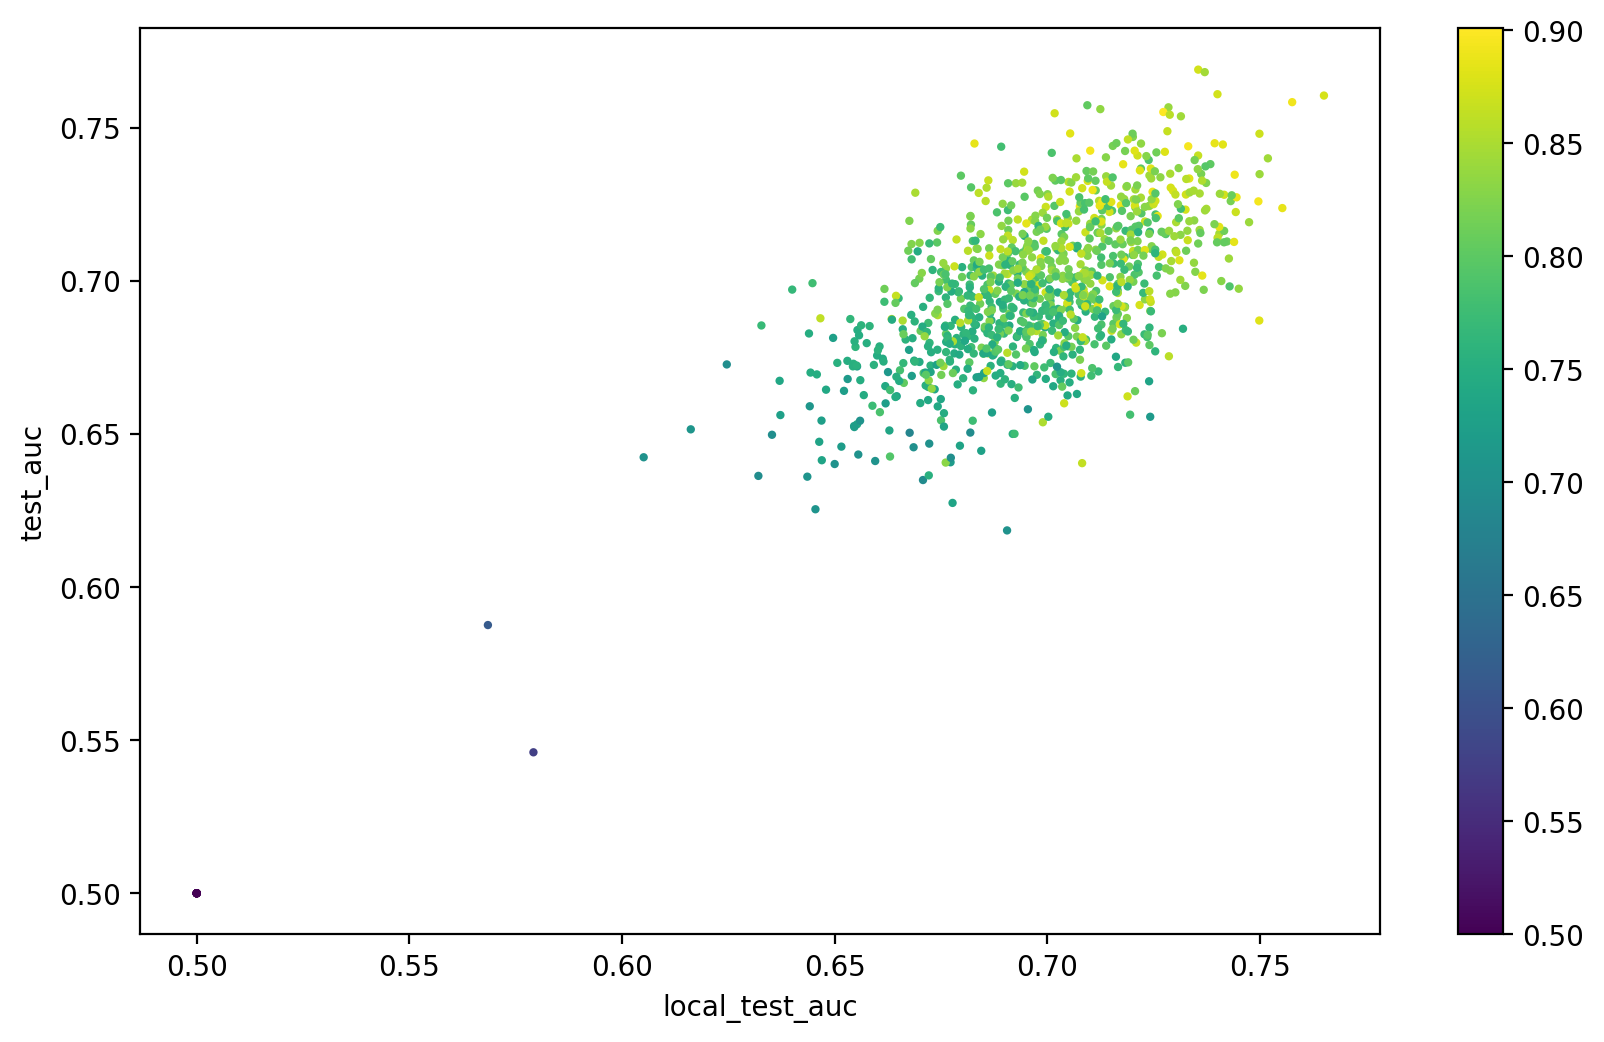

In [144]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6), dpi=200)
plt.scatter(info_df['local_test_auc'], info_df['test_auc'],
            c=info_df['global_auc'], s=4)
plt.xlabel('local_test_auc')
plt.ylabel('test_auc')
plt.colorbar()


# 输出模块

In [145]:
import time
import numpy as np
from sklearn.metrics import roc_auc_score

date = time.strftime("%Y%m%d-%H%M%S", time.localtime())
res_num = np.argsort([-i for i in info_df['local_test_auc']])

# 选择前n个结果进行平均（手动指定or在本地测试集排序选出）
if True:
    max_auc = -1
    list_temp = []
    auc_seq = []
    for i in range(N):
        list_temp.append(local_test_labels[res_num[i]])
        # 算数平均
        # temp = np.mean(list_temp, axis=0)
        # 几何平均(better)
        temp = np.exp(np.mean(np.log(list_temp), axis=0))
        temp_auc = roc_auc_score(Y_local_test, temp)
        # print(i, temp_auc)
        auc_seq.append(temp_auc)
        if temp_auc > max_auc:
            max_auc = temp_auc
            n = i+1
else:
    n = 40
    n = min(N, n)

res_num = res_num[0:n]

#final_pred_label = np.mean([pred_labels[i] for i in res_num], axis=0)
final_pred_label = np.exp(
    np.mean(np.log([pred_labels[i] for i in res_num]), axis=0))
#local_auc = roc_auc_score(y_test, final_pred_label)
print("本地测试集前", n, "个auc为", [
      list(info_df['local_test_auc'])[i] for i in res_num], sep="")
print("平均之后local_test_AUC为", max_auc, sep="")

res = pd.DataFrame({
    'cust_id': list(df_test["cust_id"]),
    'label': final_pred_label,
})
res.to_csv("./output/result"+date+".csv", encoding="utf-8", index=False)


0 0.7650833595470272
1 0.7741145014155395
2 0.7789462094998427
3 0.779877319911922
4 0.7786851211072665
5 0.7788015099087764
6 0.7809657124882039
7 0.7802831078955647
8 0.7807832651777288
9 0.7821358917898711
10 0.7824284366152877
11 0.7822334067316765
12 0.7814595784837999
13 0.7820195029883611
14 0.7817489776659327
15 0.7807895564642969
16 0.7802956904687008
17 0.7805347593582888
18 0.7802720981440704
19 0.7797011638880151
20 0.7799716892104436
21 0.780059767222397
22 0.7801887385970431
23 0.7800188738597043
24 0.7790374331550802
25 0.7789808115759673
26 0.7791884240327147
27 0.7790657439446367
28 0.7789116074237182
29 0.7785577225542624
30 0.7786410821012897
31 0.7781881094683862
32 0.7777131173324945
33 0.7772334067316766
34 0.7771217363950929
35 0.7769424347279017
36 0.7769927650204467
37 0.776709657124882
38 0.7770368040264235
39 0.7770084932368669
40 0.77683233721296
41 0.7767190940547342
42 0.7761277131173325
43 0.7759106637307328
44 0.7754734193142498
45 0.7751745832022648
46 

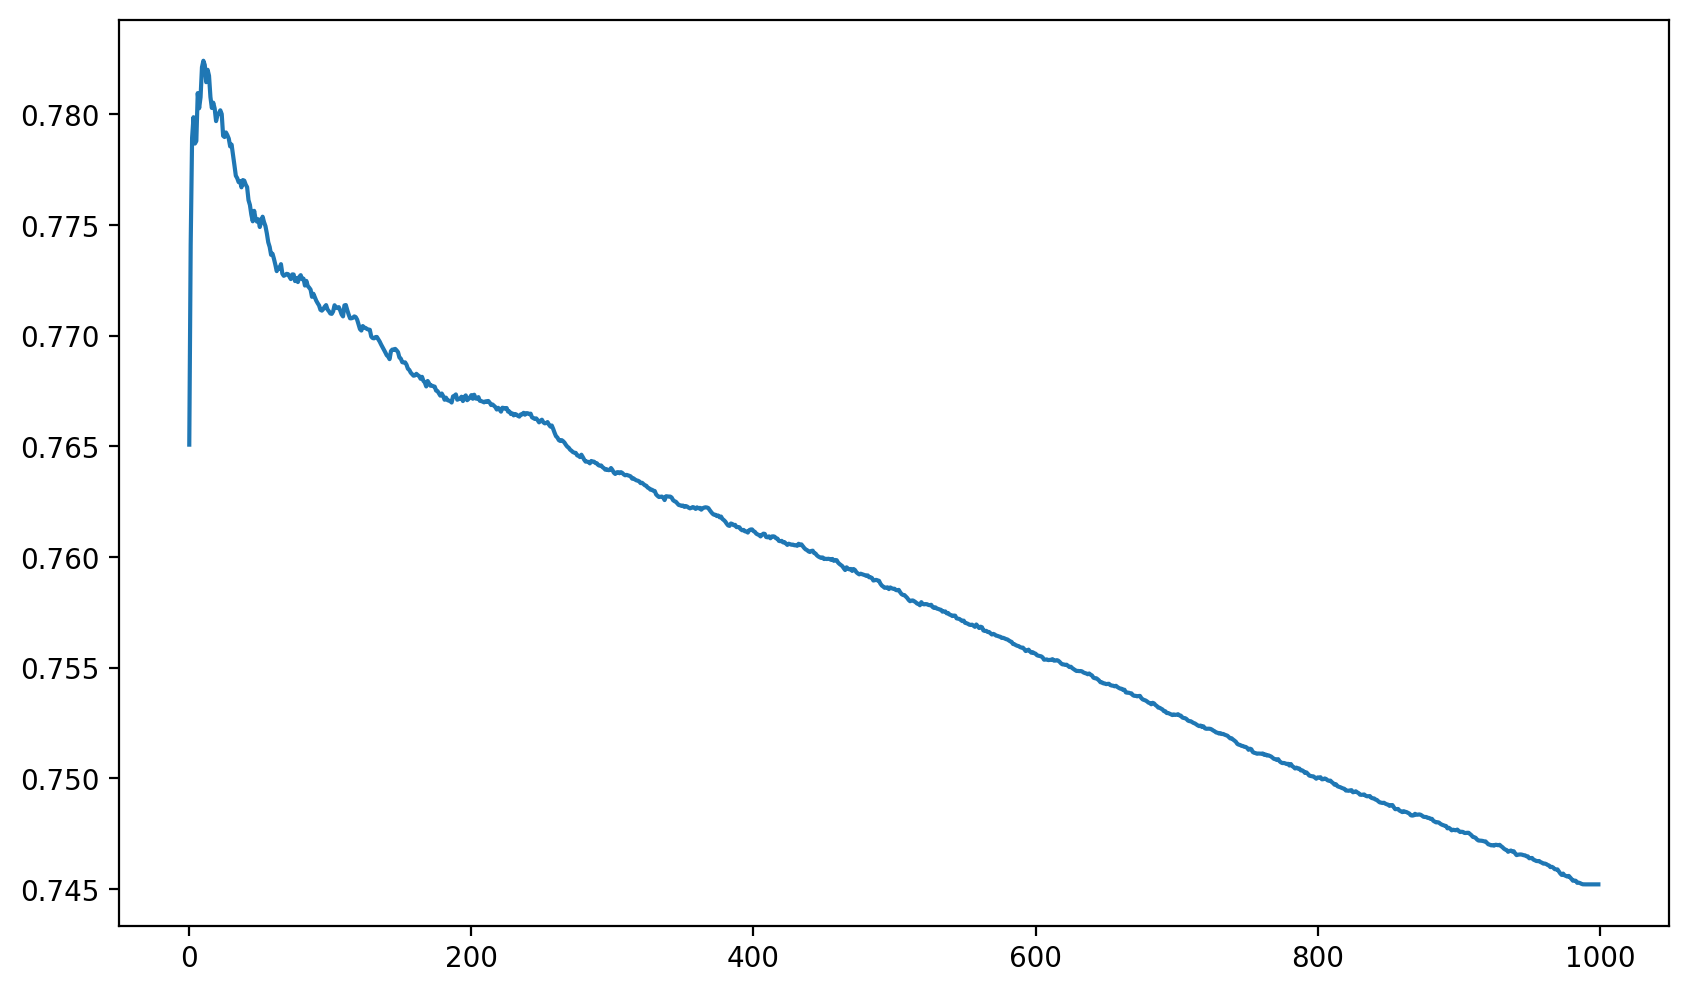

In [146]:

plt.figure(figsize=(10, 6), dpi=200)
plt.plot(list(range(N)), auc_seq)


# 一些tips

* 提升n有一定提升(如何确定n？)
  * n=40 0.6763
  * n=10 0.6728
  * n=100 0.6774
  * 太大也不好

# 一些进展

* 随机参数
* XGB模型
* 本地测试集auc较高（0.75+）
* 部分类型变量进行了one-hot处理
* 把细分表除了loan与主表合并

# tbd

* 处理细分表的loan，给出指标
* 确定变量类型，以便对所有（or重要）分类变量进行one-hot处理
* 新模型？

## 10-12
* 0.6824（这次我留了代码\doge）
* 把-99变为-1，本地有提升
* 划出了一个本地测试集
  * 本地测试集（固定）d_localtest
  * 训练集（固定）
    * 评估集（每次的模型不同）dtest
    * 真正的训练集（每次的模型不同）dtrain
* 添加参数nan_num（然并卵）
* tbd
  * 找特征
  * 加x
  * 分析一下参数作用

# 记录
* 1014-4
  * 0.6823
  * 证据权重
  * 未添加贷款记录表
  * 按test auc排序
* 1014-5
  * 0.6925
  * 按local test auc排序
* 1015-1
  * 0.6834
  * 处理-99
* 1015-2
  * 0.6628
  * 添加贷款记录表
* 1015-3
  * 0.6772
  * 不处理-99
  * 去除贷款记录表
  * 添加了type-col
* 1015-4
  * 0.6811
  * 不做证据权重
* 1015-5
  * 0.6765
  * gamma=0